# Test on changes in spectra when square region in gridpoints used to calculate spatial spectra versus sqaured in degrees.  
### Test done in Gulf Stream region.

In [67]:
%matplotlib inline

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [68]:
from dask.distributed import Client, progress
# HPC
# client = Client(scheduler_file='/glade/scratch/jhamman/scheduler.json')
# client

from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=10)
cluster

/srv/conda/lib/python3.6/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


In [69]:
client = Client(cluster)
client

Client Scheduler: tcp://10.32.2.48:42323 Dashboard: /user/0000-0002-5878-4501/proxy/42143/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [70]:
import gcsfs

fs = gcsfs.GCSFileSystem(project='pangeo-181919', token='anon', access='read_only')

In [71]:
gcsmap = gcsfs.mapping.GCSMap('pangeo-data/llc4320_surface/Eta',gcs=fs,check=False,create=False)
ds = xr.open_zarr(gcsmap)

In [72]:
ds

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, j: 4320, time: 9030)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
Data variables:
    Eta      (time, face, j, i) float32 dask.array<shape=(9030, 13, 4320, 4320), chunksize=(1, 1, 4320, 4320)>
Attributes:
    Conventions:  CF-1.6
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...
    source:       MITgcm
    title:        netCDF wrapper of MITgcm MDS binary data

In [73]:
gcsmapgrid = gcsfs.mapping.GCSMap('pangeo-data/llc4320_surface/grid',gcs=fs,check=False,create=False)
dsgrid = xr.open_zarr(gcsmapgrid)

In [74]:
dsgrid

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k_p1: 2, time: 9030)
Coordinates:
    CS       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    Depth    (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    PHrefC   float32 ...
    PHrefF   (k_p1) float32 dask.array<shape=(2,), chunksize=(2,)>
    SN       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    XC       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    XG       (face, j_g, i_g) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YC       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YG       (face, j_g, i_g) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    Z        float32 ...
    Zl       float32 ...
    Zp1      (k_p1) float32 dask.array<shape=(2,), chunksize=(2

In [75]:
lat = dsgrid.YC
lon = dsgrid.XC

In [76]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.cm as mplcm

seq_cmap = mplcm.Blues
div_cmap = mplcm.seismic

In [77]:
def plot_surf(sub,data,lon,lat,vmin,vmax,cmap,title,date):
    
    ax = plt.subplot(sub,projection=ccrs.PlateCarree(central_longitude=0))
    land = cfeature.GSHHSFeature(scale='intermediate',
                                 levels=[1],
                                 facecolor=cfeature.COLORS['land'])
    ax.add_feature(land)
    gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                      alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.tick_params('both',labelsize=22)

    plt.pcolormesh(lon,lat,data,cmap=cmap,vmin=vmin,vmax=vmax )
    plt.colorbar(orientation='horizontal',pad=0.1, aspect=50)
    plt.title(title)
    ax.text(0.57, -0.08, date, transform=ax.transAxes)



In [78]:
import PowerSpec_old as ps
m2km = 1.E3

In [79]:
data = ds.sel(time='2012-01-01T01:00:00',face=10)['Eta'] #.values
lonn = lon.sel(face=10) #.values
latt = lat.sel(face=10) #.values

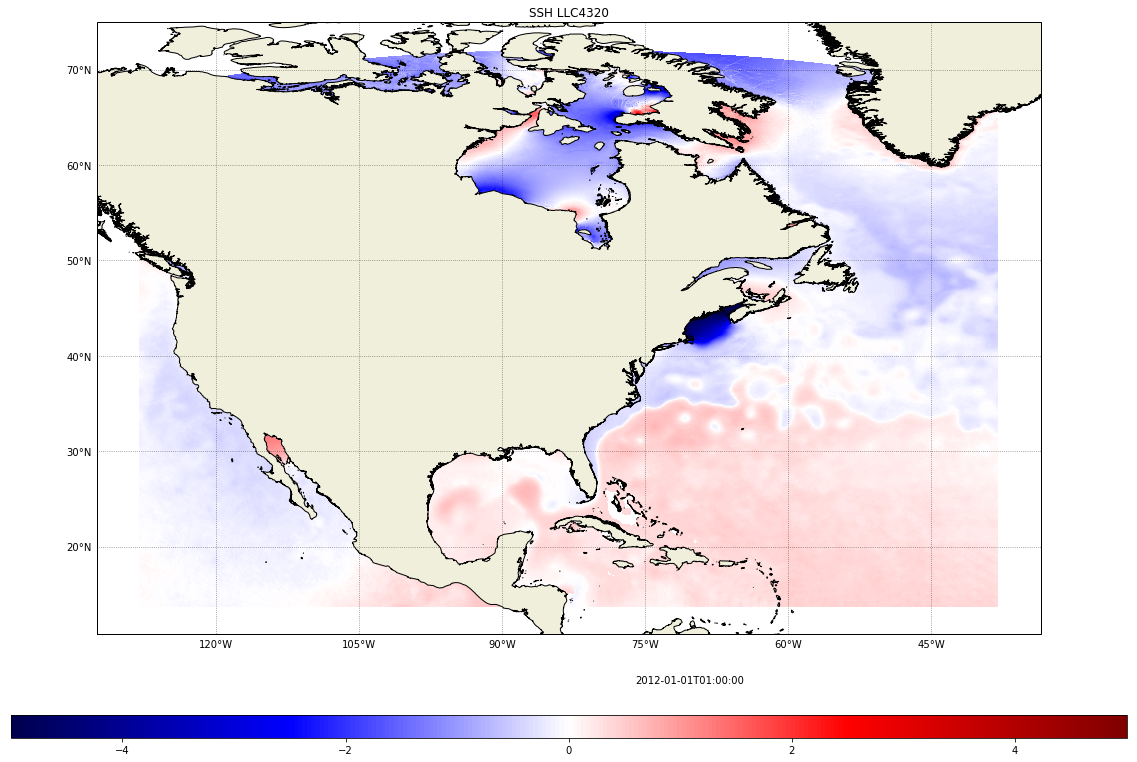

In [80]:
fig = plt.figure(figsize=(20,15))
plot_surf(111,data,lonn,latt,-5,5,div_cmap,'SSH LLC4320','2012-01-01T01:00:00')

# Sqaured region in degrees:

In [81]:
lomin = -49.5
lomax = -47
lamin = 34
lamax = 36.5

In [82]:
lonEbox = lonn.where((lonn>lomin)&(lonn<lomax)&(latt>lamin)&(latt<lamax), drop=True)
latEbox = latt.where((lonn>lomin)&(lonn<lomax)&(latt>lamin)&(latt<lamax), drop=True)
adtEbox = data.where((lonn>lomin)&(lonn<lomax)&(latt>lamin)&(latt<lamax), drop=True)

In [83]:
lonEbox.shape

(120, 159)

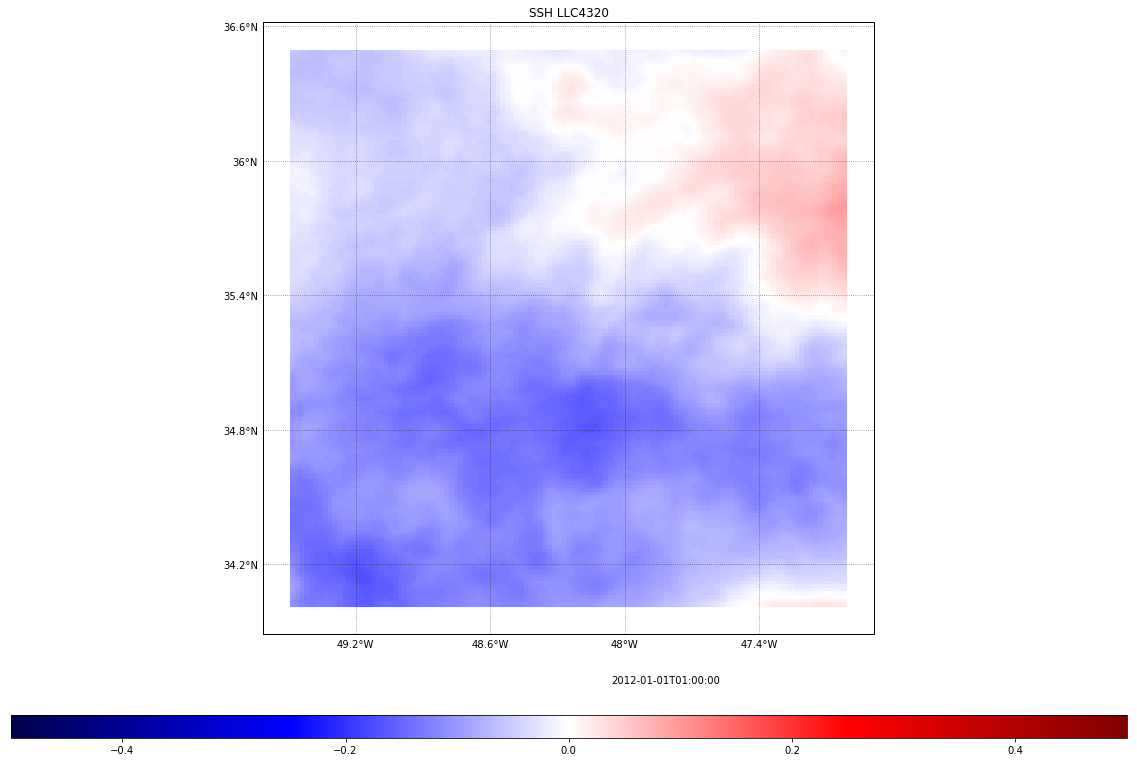

In [84]:
fig = plt.figure(figsize=(20,15))
plot_surf(111, adtEbox, lonEbox, latEbox, -.5, 0.5, div_cmap, 'SSH LLC4320', '2012-01-01T01:00:00')


In [85]:
np.diff(lonEbox)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [86]:
np.unique(np.diff(lonEbox) > 0.)

array([False])

In [87]:
np.unique(np.diff(latEbox) > 0.)

array([False])

# --> MITgcm --> regular in degrees

# One file spectra:

In [88]:
lon_box_D = lonEbox.to_masked_array()
lat_box_D = latEbox.to_masked_array()
adt_box_D = adtEbox.to_masked_array()

In [89]:
x, y, data = ps.interpolate(adt_box_D, lon_box_D, lat_box_D, interp=None)
#x, y, data = ps.interpolate(adt_box, lon_box, lat_box, interp='basemap')
# - check if data contains nan. If yes,replace with interpolated values.
##data = ps.isdata_contain_nan(data)
# - compute sepctrum
kstep_ssh_D, pspec_ssh_D = ps.get_spectrum(data, x, y, window='tukey', detrend='both')


# Squared region in gridpoints:

In [90]:
lon_box_D.shape

(120, 159)

# --> subselect so that 120x120

In [91]:
lon_box_G1 = lon_box_D[:,0:120]
lat_box_G1 = lat_box_D[:,0:120]
adt_box_G1 = adt_box_D[:,0:120]

In [92]:
x, y, data = ps.interpolate(adt_box_G1, lon_box_G1, lat_box_G1, interp=None)

kstep_ssh_G1, pspec_ssh_G1 = ps.get_spectrum(data, x, y, window='tukey', detrend='both')


In [93]:
lon_box_G2 = lon_box_D[:,159-120::]
lat_box_G2 = lat_box_D[:,159-120::]
adt_box_G2 = adt_box_D[:,159-120::]

In [94]:
x, y, data = ps.interpolate(adt_box_G2, lon_box_G2, lat_box_G2, interp=None)

kstep_ssh_G2, pspec_ssh_G2 = ps.get_spectrum(data, x, y, window='tukey', detrend='both')


# Plots:

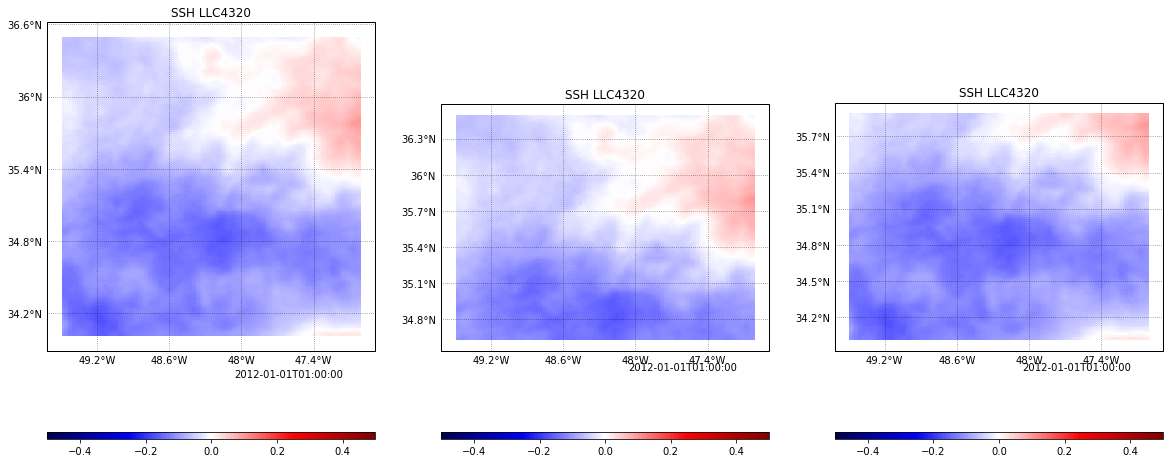

In [95]:
fig = plt.figure(figsize=(20,15))
plot_surf(131, adtEbox, lonEbox, latEbox, -.5, 0.5, div_cmap, 'SSH LLC4320', '2012-01-01T01:00:00')
plot_surf(132, adt_box_G1, lon_box_G1, lat_box_G1, -.5, 0.5, div_cmap, 'SSH LLC4320', '2012-01-01T01:00:00')
plot_surf(133, adt_box_G2, lon_box_G2, lat_box_G2, -.5, 0.5, div_cmap, 'SSH LLC4320', '2012-01-01T01:00:00')


Text(0, 0.5, 'Spectral density [$m$$^2$ $/$ $cpkm$]')

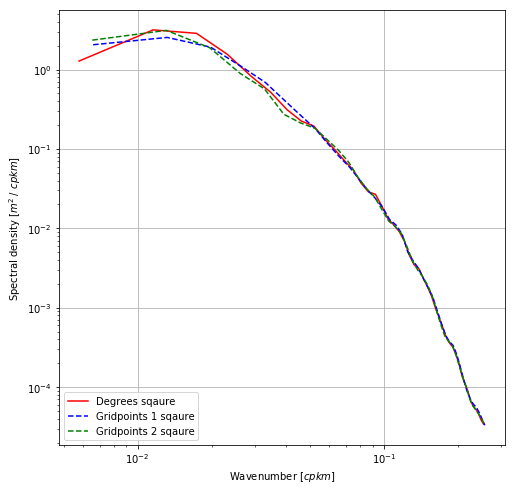

In [39]:
plt.figure(figsize=(8, 8))
ax = plt.subplot(111)
ax.loglog(kstep_ssh_D * m2km, pspec_ssh_D, 'r', label='Degrees sqaure')
ax.loglog(kstep_ssh_G1 * m2km, pspec_ssh_G1, '--b', label='Gridpoints 1 sqaure')
ax.loglog(kstep_ssh_G2 * m2km, pspec_ssh_G2, '--g', label='Gridpoints 2 sqaure')
ax.grid(True)
#ax.set_ylim([1e-5, 1e1])
#ax.set_xlim([5e-3, .2])
ax.legend(loc='lower left')
ax.set_xlabel('Wavenumber [$cpkm$]')
ax.set_ylabel('Spectral density [$m$$^2$ $/$ $cpkm$]')



# Spectra from another snapshot:

In [40]:
data = ds.sel(time='2012-07-01T01:00:00',face=10)['Eta'] #.values
lonn = lon.sel(face=10) #.values
latt = lat.sel(face=10) #.values

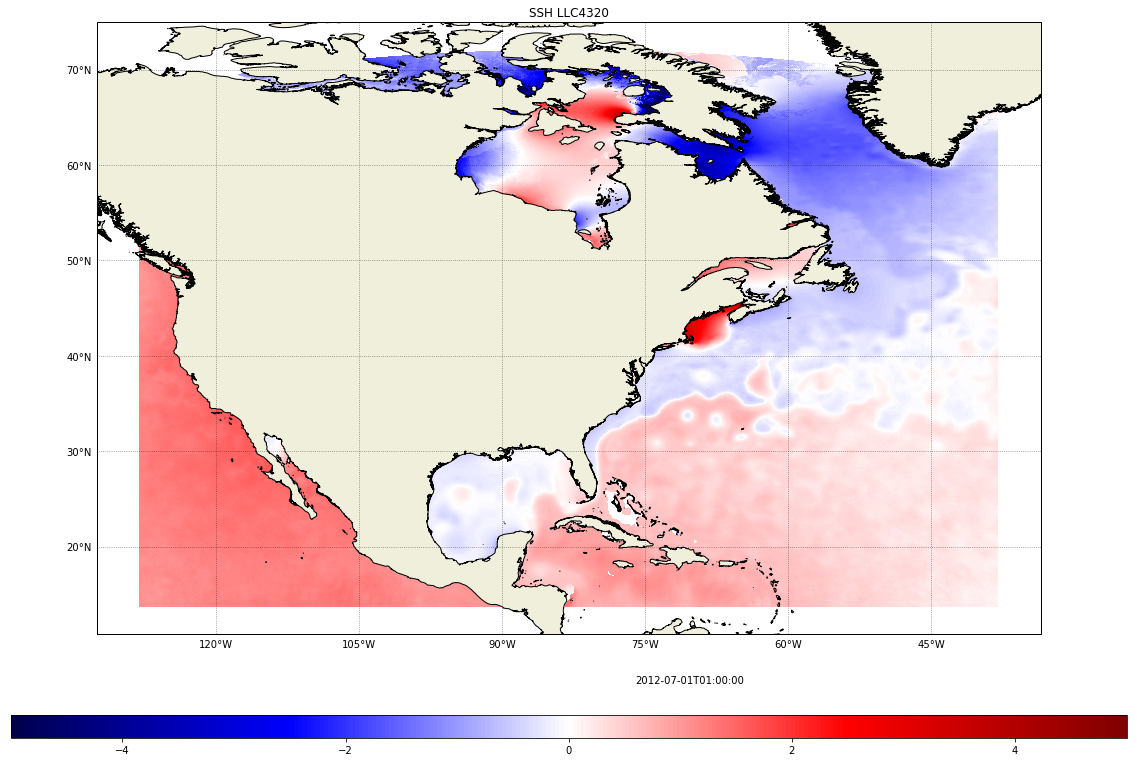

In [41]:
fig = plt.figure(figsize=(20,15))
plot_surf(111, data, lonn, latt, -5, 5, div_cmap, 'SSH LLC4320', '2012-07-01T01:00:00')

# Sqaured region in degrees:

In [42]:
lomin = -49.5
lomax = -47
lamin = 34
lamax = 36.5

In [43]:
lonEbox = lonn.where((lonn>lomin)&(lonn<lomax)&(latt>lamin)&(latt<lamax), drop=True)
latEbox = latt.where((lonn>lomin)&(lonn<lomax)&(latt>lamin)&(latt<lamax), drop=True)
adtEbox = data.where((lonn>lomin)&(lonn<lomax)&(latt>lamin)&(latt<lamax), drop=True)

In [44]:
lonEbox.shape

(120, 159)

# One file spectra:

In [46]:
lon_box_D = lonEbox.to_masked_array()
lat_box_D = latEbox.to_masked_array()
adt_box_D = adtEbox.to_masked_array()

In [47]:
x, y, data = ps.interpolate(adt_box_D, lon_box_D, lat_box_D, interp=None)
#x, y, data = ps.interpolate(adt_box, lon_box, lat_box, interp='basemap')
# - check if data contains nan. If yes,replace with interpolated values.
##data = ps.isdata_contain_nan(data)
# - compute sepctrum
kstep_ssh_D, pspec_ssh_D = ps.get_spectrum(data, x, y, window='tukey', detrend='both')


# Squared region in gridpoints:

In [48]:
lon_box_D.shape

(120, 159)

# --> subselect so that 120x120

In [49]:
lon_box_G1 = lon_box_D[:,0:120]
lat_box_G1 = lat_box_D[:,0:120]
adt_box_G1 = adt_box_D[:,0:120]

In [50]:
x, y, data = ps.interpolate(adt_box_G1, lon_box_G1, lat_box_G1, interp=None)

kstep_ssh_G1, pspec_ssh_G1 = ps.get_spectrum(data, x, y, window='tukey', detrend='both')


In [51]:
lon_box_G2 = lon_box_D[:,159-120::]
lat_box_G2 = lat_box_D[:,159-120::]
adt_box_G2 = adt_box_D[:,159-120::]

In [52]:
x, y, data = ps.interpolate(adt_box_G2, lon_box_G2, lat_box_G2, interp=None)

kstep_ssh_G2, pspec_ssh_G2 = ps.get_spectrum(data, x, y, window='tukey', detrend='both')


# Plots:

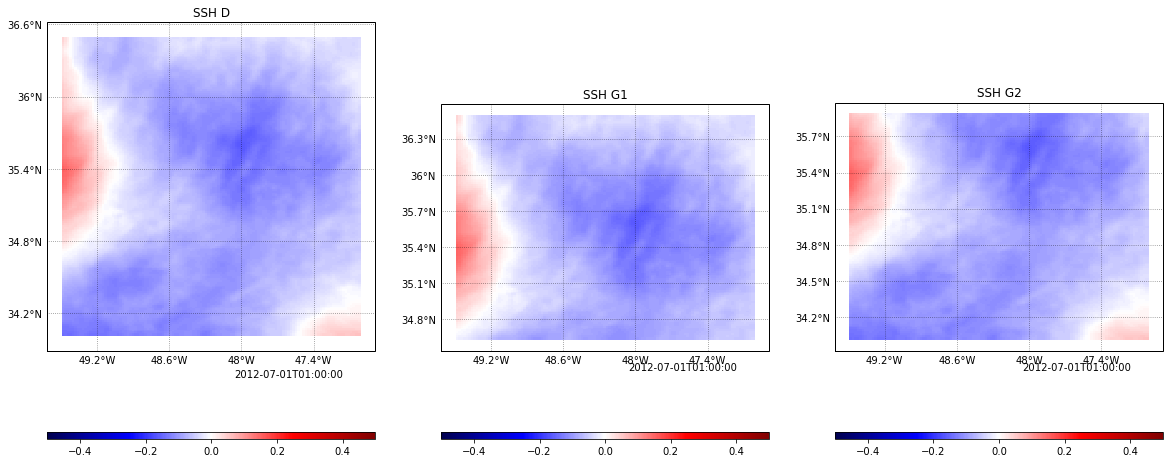

In [66]:
fig = plt.figure(figsize=(20,15))
plot_surf(131, adtEbox, lonEbox, latEbox, -.5, 0.5, div_cmap, 'SSH D', '2012-07-01T01:00:00')
plot_surf(132, adt_box_G1, lon_box_G1, lat_box_G1, -.5, 0.5, div_cmap, 'SSH G1', '2012-07-01T01:00:00')
plot_surf(133, adt_box_G2, lon_box_G2, lat_box_G2, -.5, 0.5, div_cmap, 'SSH G2', '2012-07-01T01:00:00')


Text(0, 0.5, 'Spectral density [$m$$^2$ $/$ $cpkm$]')

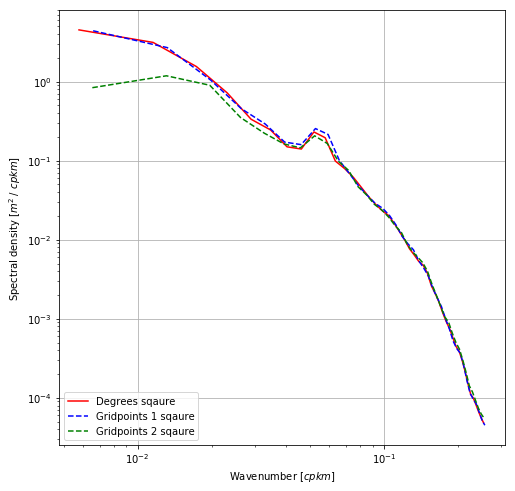

In [53]:
plt.figure(figsize=(8, 8))
ax = plt.subplot(111)
ax.loglog(kstep_ssh_D * m2km, pspec_ssh_D, 'r', label='Degrees sqaure')
ax.loglog(kstep_ssh_G1 * m2km, pspec_ssh_G1, '--b', label='Gridpoints 1 sqaure')
ax.loglog(kstep_ssh_G2 * m2km, pspec_ssh_G2, '--g', label='Gridpoints 2 sqaure')
ax.grid(True)
#ax.set_ylim([1e-5, 1e1])
#ax.set_xlim([5e-3, .2])
ax.legend(loc='lower left')
ax.set_xlabel('Wavenumber [$cpkm$]')
ax.set_ylabel('Spectral density [$m$$^2$ $/$ $cpkm$]')



In [55]:
cp 2019-04-24-GS_reg_SPECTRA_testsAJ.ipynb /home/jovyan/git/jupyterlab_pangeo/

git  notebooks
